# Проект по построению модели прогнозирования возраста покупателей

## Введение

**Вводные данные проекта:**

**Заказчик:** cетевой супермаркет «Хлеб-Соль».

**Цель проекта:** построить модель, которая по фотографии (фотофиксация в прикассовой зоне) определит приблизительный возраст человека (клиента). 

Модель необходима для следующих задач:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Дополнительные условия заказчика:**
- значение метрики MAE на тестовой выборке не больше 8.

**Данные для анализа и построения модели:** набор фотографий людей с указанием возраста.

**Этапы проекта:**

1. Загрузить данные.
2. Провести исследовательский анализ набора фотографий.
3. Подготовить данные к обучению.
4. Обучить нейронную сеть и рассчитать ее качество.
5. Сделать выводы по результатам проекта.

## Загрузка и исследовательский анализ данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# загрузим данные
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Датасет состоит из 7591 фотографии, что является недостаточным для обучения нейросети, в частности для выполнения задачи регрессии. Для решения этой проблемы используем при обучении аугментацию - увеличим выборку изображений для повышения качества модели.

In [3]:
def info_all(data):
    '''функция оценивает общую информацию о данных'''
    print('-'*50)
    print('Общая информация о данных')
    temp = data.copy() 
    list_c = data.columns
    print(temp.info())
    for col_l in list_c:
        print('-'* 25)
        print(col_l, temp[col_l].sort_values().unique())
        print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')
    print('-'*50)    
    display(data.describe()) 
    print('-'*50) 
    print('Поиск дубликатов')
    if data.duplicated().sum() == 0:
        print('Дубликаты по строкам отсутствуют')
    else:
        print('Количество дублирующихся строк:', data.duplicated().sum())
        display(data.loc[data.duplicated() == True])

In [4]:
# посмотрим общую информацию о данных
info_all(labels)

--------------------------------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
-------------------------
file_name ['000000.jpg' '000001.jpg' '000002.jpg' ... '007610.jpg' '007611.jpg'
 '007612.jpg']
file_name : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
real_age [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  93  94  95  96  97 100]
real_age

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


--------------------------------------------------
Поиск дубликатов
Дубликаты по строкам отсутствуют


Пропусков и дубликатов в данных нет, возраст людей на изображениях от 1 до 100 лет.

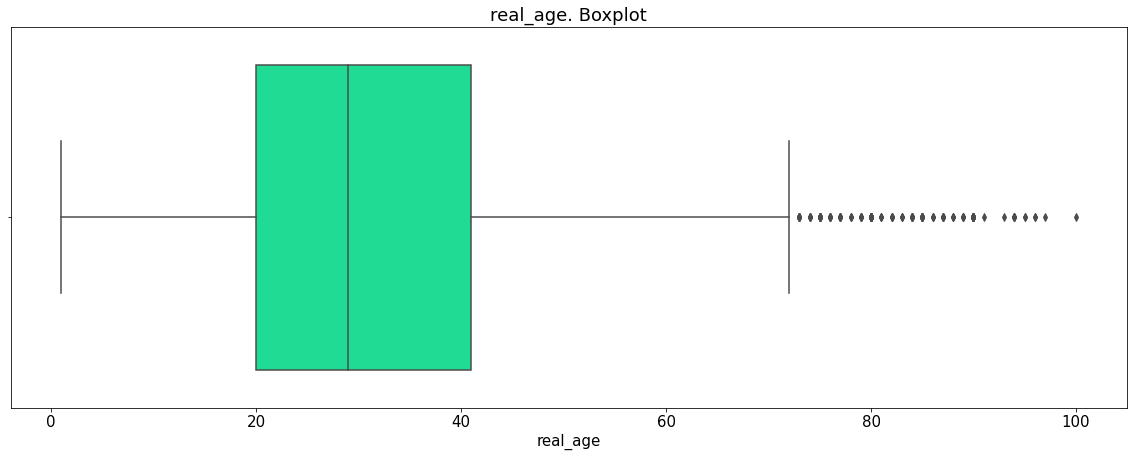

In [5]:
# посмотрим имеются ли выбросы в данных
plt.subplots(figsize=(20, 7))
plt.title('real_age' + ". Boxplot", fontsize=18)
sns.boxplot(data=labels, x=labels.real_age, color='mediumspringgreen')
plt.tick_params( labelsize = 15)
plt.xlabel('real_age', fontsize=15)
plt.show()

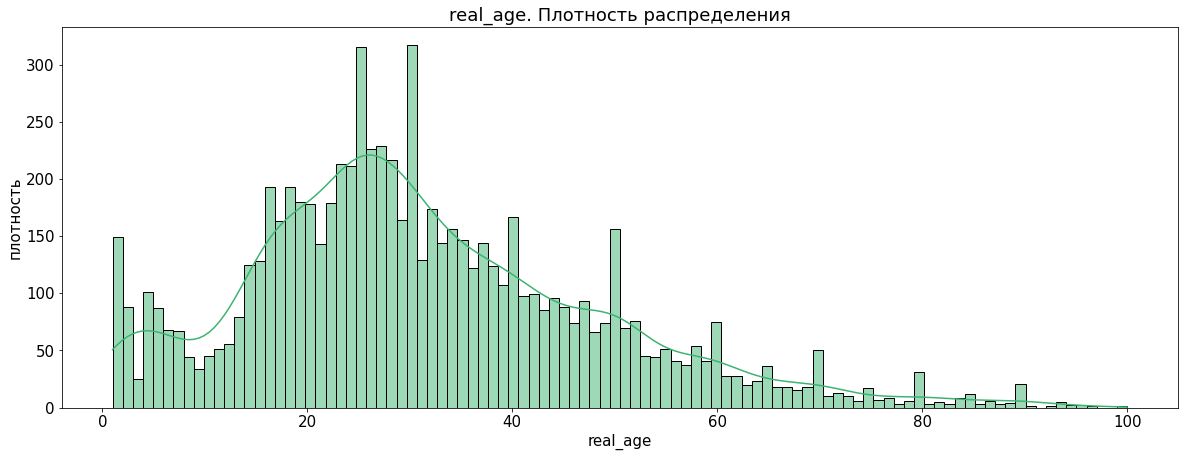

In [6]:
# оценим распределение данных по возрасту
plt.subplots(figsize=(20, 7))
sns.histplot(labels, bins=100, x='real_age', color='mediumseagreen', kde=True)
plt.title('real_age' + ". Плотность распределения", fontsize=18)
plt.ylabel('плотность', fontsize=15)
plt.xlabel('real_age', fontsize=15)
plt.tick_params( labelsize = 15)
plt.show()

**Особенности распределения датасета по возрасту:**
- Распределение скошено вправо (положительно ассиметричное). 
- В датасете представлены объекты с возрастом от 1 до 100 лет.
- Большая часть фото сконцентрирована в интервале от 20 до 30 лет, в частности наибольшее количество фотографий с возрастом 25 и 30 лет, возможно использовалось округление возраста при разметке датасета, так как подобные всплески наблюдаются в юбилейные годы (1, 25, 30, 40, 50, 60 и т.д.).

В целом распределение по возрасту не имеет критичных выбросов и аномалий.

Возраст: 5


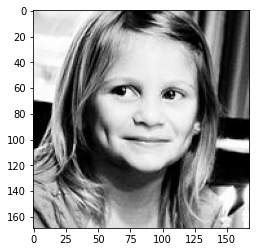

Возраст: 5


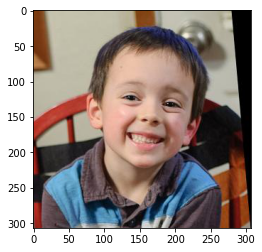

Возраст: 10


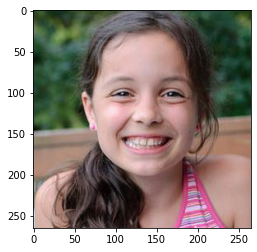

Возраст: 10


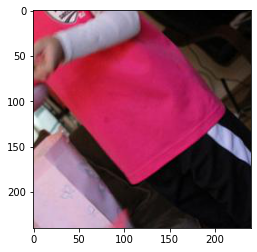

Возраст: 25


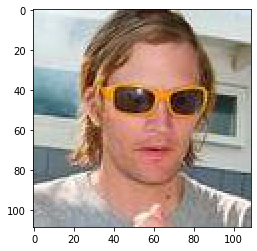

Возраст: 25


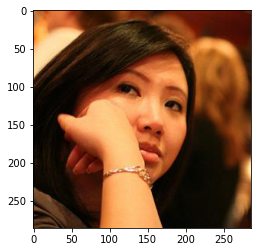

Возраст: 30


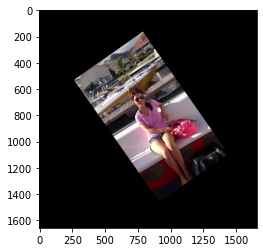

Возраст: 30


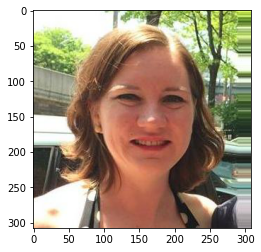

Возраст: 40


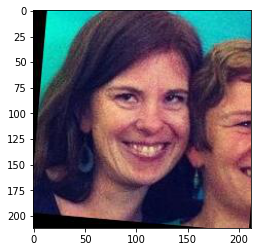

Возраст: 40


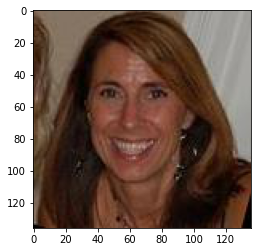

Возраст: 50


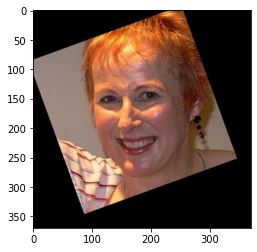

Возраст: 50


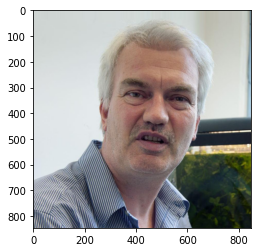

Возраст: 60


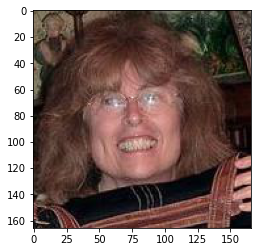

Возраст: 60


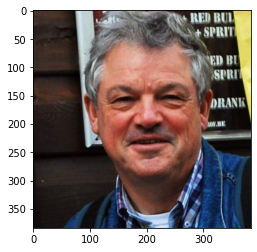

In [7]:
# посмотрим 10-15 фотографий
# выберем несколько возрастов 5, 10, 25, 30, 40, 50, 60 лет

for x in [5,10,25,30,40,50,60]:
    count=0 
    for index in labels[labels['real_age']==x].index:
        count+=1
        if count <=2:
            image=Image.open('/datasets/faces/final_files/' + labels['file_name'][index])
            print('Возраст:', x)
            plt.imshow(image)
            plt.show()

**Вывод по исследовательскому анализу:**

Датасет состоит из 7591 фотографии людей с указанием возраста от 1 до 100 лет. Данного количества объектов недостаточно для обучения нейросети, в частности для выполнения задачи регрессии. Для решения этой проблемы используем при обучении аугментацию - увеличим выборку изображений для повышения качества модели с помощью отражения по горизонтали.

**Большая часть фото сконцентрирована в интервале от 20 до 30 лет**, в частности наибольшее количество фотографий с возрастом 25 и 30 лет. Возможно использовалось округление возраста при разметке датасета, так как подобные всплески наблюдаются в юбилейные годы (1, 25, 30, 40, 50, 60 и т.д.).

В целом распределение по возрасту не имеет критичных выбросов и аномалий. Пропуски и дубликаты отсутствуют.

При выводе изображений на экран видим, что фото соответствуют указанному в метках возрасту. 

**Описание данных при визуальной оценке датасета:**
- большая часть датасета представляет собой лица людей разных возрастов крупным планом;
- в датасете присутствуют черно-белые фотографии;
- на части фото отсутствует лицо;
- часть фото подвергнуты преобразованиям в виде поворотов.

## Обучение модели

Выполним обучение модели.

Так как код был запущен в отдельном GPU-тренажере, то оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

optimizer_adam = Adam(lr=0.0001)

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255.,
                                       validation_split=0.25,
                                       horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='training') 
        
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255.,
                                 validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='validation') 
        
    return test_gen_flow


def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))    
    model.compile(loss='mse', optimizer=optimizer_adam, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch=len(train_data)
    if validation_steps is None:
        validation_steps=len(test_data)
    model.fit(train_data,
        validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)
        
    return model

```

**Результаты обучения:**

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 70s - loss: 321.8804 - mae: 12.6106 - val_loss: 1127.4567 - val_mae: 29.0707
Epoch 2/10
178/178 - 54s - loss: 86.4571 - mae: 6.9620 - val_loss: 499.8147 - val_mae: 17.1715
Epoch 3/10
178/178 - 76s - loss: 55.7119 - mae: 5.6479 - val_loss: 223.9677 - val_mae: 11.1247
Epoch 4/10
178/178 - 76s - loss: 37.9906 - mae: 4.7068 - val_loss: 107.7298 - val_mae: 7.7518
Epoch 5/10
178/178 - 65s - loss: 29.8783 - mae: 4.1311 - val_loss: 95.5081 - val_mae: 7.5139
Epoch 6/10
178/178 - 59s - loss: 20.5492 - mae: 3.5070 - val_loss: 68.3171 - val_mae: 6.2734
Epoch 7/10
178/178 - 53s - loss: 17.1299 - mae: 3.1470 - val_loss: 80.9670 - val_mae: 6.6450
Epoch 8/10
178/178 - 61s - loss: 13.5217 - mae: 2.8031 - val_loss: 62.7557 - val_mae: 5.9492
Epoch 9/10
178/178 - 52s - loss: 11.4076 - mae: 2.5388 - val_loss: 62.4468 - val_mae: 6.0551
Epoch 10/10
178/178 - 44s - loss: 9.7407 - mae: 2.3491 - val_loss: 58.9598 - val_mae: 5.7759

60/60 - 10s - loss: 58.9598 - mae: 5.7759
Test MAE: 5.7759
```

**Вывод:** Модель обучена с требуемым результатом MAE не более 8 (MAE 5.8 и MSE 59).


## Анализ обученной модели

**Построена модель с архитектурой ResNet50:**
- с предобученными весами на датасете ImageNet без использования заморозки весов;
- верхушкой из слоев GlobalAveragePooling2D и Dense с функцией активации relu;
- размер батча: 32;
- алгоритм оптимизации: adam с шагом 0.0001;
- количество эпох: 10;
- применена аугментация (отражение по горизонтали);
- функция потерь: MSE; 
- целевая метрика: MAE.

Результаты модели:
- MAE = 5.7759 (соответствует целям проекта - MAE не больше 8);
- MSE = 58.9598.

Переобучение не наблюдалось.

## Выводы по проекту

В ходе проекта были **реализованы следующие этапы:**
1. Загружены данные и проведен исследовательский анализ - датасет не имеет существенных выбросов, аномалий, пропусков и дубликатов. При выводе изображений на экран видим, что фото соответствуют указанному в метках возрасту.
2. Обучена модель с архитектурой ResNet50 с достижением целевого результата MAE ниже 8 (5.8).

**Выводы по результатам проекта:**
- модель предсказывает возраст с ошибкой ~ 6 лет;
- полученная модель может быть использована для анализа покупок и предложения товаров, которые могут заинтересовать покупателей этой возрастной группы;
- скорее всего, модель не подойдет для целей контроля кассиров в части продажи алкоголя несовершеннолетним, так как отклонение возраста в 6 лет слишком существенное. Необходима доработка модели с целью улучшения качества предсказаний.